In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import numpy as np
import os, sys, inspect
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

np.random.seed(123456789)  # for reproducibility

In [3]:
# Set data path
data_dir = "C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/input/" # "Path to data files (train and test)")
logs_dir = "C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/"#"Logging path")
mode = "train" #"mode: train (Default)/ test")

In [4]:
# Set hyperparamters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
MAX_ITERATIONS = 1000
REGULARIZATION = 1e-3
IMAGE_SIZE = 48
NUM_LABELS = 7
VALIDATION_PERCENT = 0.1

In [5]:
def add_to_regularization_loss(W, b):
    tf.add_to_collection("losses", tf.nn.l2_loss(W))
    tf.add_to_collection("losses", tf.nn.l2_loss(b))

def weight_variable(shape, stddev=0.02, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)
    
def bias_variable(shape, name=None):
    initial = tf.constant(0.0, shape=shape)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)    

In [6]:
def conv2d_basic(x, W, bias):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")
    return tf.nn.bias_add(conv, bias)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [7]:
def emotionCNN(dataset):
    with tf.name_scope("conv1") as scope:
        tf.summary.histogram("W_conv1", weights['wc1'])
        tf.summary.histogram("b_conv1", biases['bc1'])
        conv_1 = tf.nn.conv2d(dataset, weights['wc1'], strides=[1, 1, 1, 1], padding="SAME")
        h_conv1 = tf.nn.bias_add(conv_1, biases['bc1'])
        h_1 = tf.nn.relu(h_conv1)
        h_pool1 = max_pool_2x2(h_1)
        add_to_regularization_loss(weights['wc1'], biases['bc1'])

    with tf.name_scope("conv2") as scope:
        tf.summary.histogram("W_conv2", weights['wc2'])
        tf.summary.histogram("b_conv2", biases['bc2'])
        conv_2 = tf.nn.conv2d(h_pool1, weights['wc2'], strides=[1, 1, 1, 1], padding="SAME")
        h_conv2 = tf.nn.bias_add(conv_2, biases['bc2'])
        h_2 = tf.nn.relu(h_conv2)
        h_pool2 = max_pool_2x2(h_2)
        add_to_regularization_loss(weights['wc2'], biases['bc2'])

    with tf.name_scope("fc_1") as scope:
        prob = 0.5
        image_size = IMAGE_SIZE // 4
        h_flat = tf.reshape(h_pool2, [-1, image_size * image_size * 64])
        tf.summary.histogram("W_fc1", weights['wf1'])
        tf.summary.histogram("b_fc1", biases['bf1'])
        h_fc1 = tf.nn.relu(tf.matmul(h_flat, weights['wf1']) + biases['bf1'])
        h_fc1_dropout = tf.nn.dropout(h_fc1, prob)
        
    with tf.name_scope("fc_2") as scope:
        tf.summary.histogram("W_fc2", weights['wf2'])
        tf.summary.histogram("b_fc2", biases['bf2'])
        pred = tf.matmul(h_fc1_dropout, weights['wf2']) + biases['bf2']

    return pred

In [8]:
weights = {
    'wc1': weight_variable([5, 5, 1, 32], name="W_conv1"),
    'wc2': weight_variable([3, 3, 32, 64],name="W_conv2"),
    'wf1': weight_variable([int((IMAGE_SIZE // 4) * (IMAGE_SIZE // 4)) * 64, 256],name="W_fc1"),
    'wf2': weight_variable([256, NUM_LABELS], name="W_fc2")
}

biases = {
    'bc1': bias_variable([32], name="b_conv1"),
    'bc2': bias_variable([64], name="b_conv2"),
    'bf1': bias_variable([256], name="b_fc1"),
    'bf2': bias_variable([NUM_LABELS], name="b_fc2")
}

In [9]:
def loss(pred, label):
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=label))
    tf.summary.scalar('Entropy', cross_entropy_loss)
    reg_losses = tf.add_n(tf.get_collection("losses"))
    tf.summary.scalar('Reg_loss', reg_losses)
    return cross_entropy_loss + REGULARIZATION * reg_losses

def train(loss, step):
    return tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss, global_step=step)

def get_next_batch(images, labels, step):
    offset = (step * BATCH_SIZE) % (images.shape[0] - BATCH_SIZE)
    batch_images = images[offset: offset + BATCH_SIZE]
    batch_labels = labels[offset:offset + BATCH_SIZE]
    return batch_images, batch_labels

In [10]:
# For training 
train_error_list = []
train_step_list = []

# For validation 
valid_error_list = []
valid_step_list = []

In [11]:
import pickle

def read_data(data_dir, force=False):
    def create_onehot_label(x):
        label = np.zeros((1, NUM_LABELS), dtype=np.float32)
        label[:, int(x)] = 1
        return label

    pickle_file = os.path.join(data_dir, "EmotionDetectorData.pickle")
    if force or not os.path.exists(pickle_file):
        train_filename = os.path.join(data_dir, "train.csv")
        data_frame = pd.read_csv(train_filename)
        data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0)
        data_frame = data_frame.dropna()
        print("Reading train.csv ...")

        train_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
        print(train_images.shape)
        train_labels = np.array(list(map(create_onehot_label, data_frame['Emotion'].values))).reshape(-1, NUM_LABELS)
        print(train_labels.shape)

        permutations = np.random.permutation(train_images.shape[0])
        train_images = train_images[permutations]
        train_labels = train_labels[permutations]
        validation_percent = int(train_images.shape[0] * VALIDATION_PERCENT)
        validation_images = train_images[:validation_percent]
        validation_labels = train_labels[:validation_percent]
        train_images = train_images[validation_percent:]
        train_labels = train_labels[validation_percent:]

        print("Reading test.csv ...")
        test_filename = os.path.join(data_dir, "test.csv")
        data_frame = pd.read_csv(test_filename)
        data_frame['Pixels'] = data_frame['Pixels'].apply(lambda x: np.fromstring(x, sep=" ") / 255.0)
        data_frame = data_frame.dropna()
        test_images = np.vstack(data_frame['Pixels']).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

        with open(pickle_file, "wb") as file:
            try:
                print('Picking ...')
                save = {
                    "train_images": train_images,
                    "train_labels": train_labels,
                    "validation_images": validation_images,
                    "validation_labels": validation_labels,
                    "test_images": test_images,
                }
                pickle.dump(save, file, pickle.HIGHEST_PROTOCOL)

            except:
                print("Unable to pickle file :/")

    with open(pickle_file, "rb") as file:
        save = pickle.load(file)
        train_images = save["train_images"]
        train_labels = save["train_labels"]
        validation_images = save["validation_images"]
        validation_labels = save["validation_labels"]
        test_images = save["test_images"]

    return train_images, train_labels, validation_images, validation_labels, test_images

In [12]:
def main():
    train_images, train_labels, valid_images, valid_labels, test_images = read_data(data_dir)
    print("Training set size: %s" % train_images.shape[0])
    print('Validation set size: %s' % valid_images.shape[0])
    print("Test set size: %s" % test_images.shape[0])

    global_step = tf.Variable(0, trainable=False)
    dropout_prob = tf.placeholder(tf.float32)
    input_dataset = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 1],name="input")
    input_labels = tf.placeholder(tf.float32, [None, NUM_LABELS])

    pred = emotionCNN(input_dataset)
    output_pred = tf.nn.softmax(pred,name="output")
    loss_val = loss(pred, input_labels)
    train_op = train(loss_val, global_step)

    summary_op = tf.summary.merge_all()
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        summary_writer = tf.summary.FileWriter(logs_dir, sess.graph)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(logs_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print("Model Restored!")

        for step in range(MAX_ITERATIONS):
            batch_image, batch_label = get_next_batch(train_images, train_labels, step)
            feed_dict = {input_dataset: batch_image, input_labels: batch_label}

            sess.run(train_op, feed_dict=feed_dict)
            if step % 10 == 0:
                train_loss, summary_str = sess.run([loss_val, summary_op], feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, global_step=step)
                train_error_list.append(train_loss)
                train_step_list.append(step)
                print("Training Loss: %f" % train_loss)

            if step % 100 == 0:
                valid_loss = sess.run(loss_val, feed_dict={input_dataset: valid_images, input_labels: valid_labels})
                valid_error_list.append(valid_loss)
                valid_step_list.append(step)
                print("%s Validation Loss: %f" % (datetime.now(), valid_loss))
                saver.save(sess, logs_dir + 'model.ckpt', global_step=step)
        
        plt.plot(train_step_list, train_error_list, 'r--', label='CNN training loss', linewidth=4)
        plt.title('CNN training loss per iteration')
        plt.xlabel('Iteration')
        plt.ylabel('CNN training loss')
        plt.legend(loc='upper right')
        plt.show()

        plt.plot(valid_step_list, valid_error_list, 'r--', label='CNN validation loss', linewidth=4)
        plt.title('CNN validation loss per iteration')
        plt.xlabel('Iteration')
        plt.ylabel('CNN validation loss')
        plt.legend(loc='upper right')
        plt.show()  


Training set size: 3761
Validation set size: 417
Test set size: 1312
INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Tensorflow/Section 8/Logs/CNN_logs/model.ckpt-900
Model Restored!
Training Loss: 0.386602
2018-07-06 15:53:25.513493 Validation Loss: 0.810009
Training Loss: 0.481620
Training Loss: 0.370222
Training Loss: 0.471144
Training Loss: 0.362614
Training Loss: 0.433557
Training Loss: 0.436976
Training Loss: 0.356736
Training Loss: 0.465622
Training Loss: 0.376912
Training Loss: 0.414154
2018-07-06 15:54:38.439493 Validation Loss: 0.869016
Training Loss: 0.433004
Training Loss: 0.299128
Training Loss: 0.298959
Training Loss: 0.359506
Training Loss: 0.332685
Training Loss: 0.331854
Training Loss: 0.393195
Training Loss: 0.318387
Training Loss: 0.293925
Training Loss: 0.337425
2018-07-06 15:55:40.250493 Validation Loss: 0.883816
Training Loss: 0.433522
Training Loss: 0.352132
Training Loss: 0.399054
Training Loss: 0.388594
Training Loss: 0.231846
Train

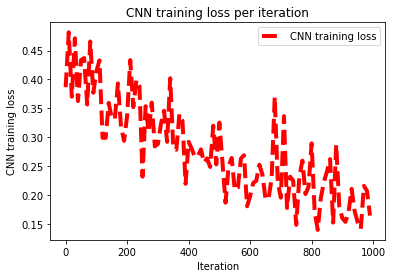

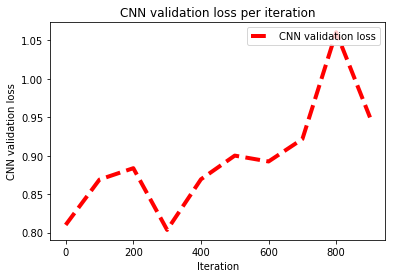

In [13]:
main()

Testing the model on your own image

In [14]:
from scipy import misc
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import os, sys, inspect
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import Utility
from Utility import testResult

from tensorflow.python.framework import ops
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [15]:
def evaluateOnSampleImage(imageFile):
    emotion = {0:'anger', 1:'disgust',\
           2:'fear',3:'happy',\
           4:'sad',5:'surprise',6:'neutral'}

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

    img = mpimg.imread(imageFile)     
    gray = rgb2gray(img)
    plt.imshow(gray, cmap = plt.get_cmap('gray'))
    plt.show()

    train_images, train_labels, valid_images, valid_labels, test_images = Utility.read_data(data_dir)

    sess = tf.InteractiveSession()

    new_saver = tf.train.import_meta_graph('C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/model.ckpt-900.meta')
    new_saver.restore(sess, 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/model.ckpt-900')
    tf.get_default_graph().as_graph_def()

    x = sess.graph.get_tensor_by_name("input:0")
    y_conv = sess.graph.get_tensor_by_name("output:0")

    image_0 = np.resize(gray,(1,48,48,1))
    tResult = testResult()
    num_evaluations = 5000

    for i in range(0,num_evaluations):
        result = sess.run(y_conv, feed_dict={x:image_0})
        label = sess.run(tf.argmax(result, 1))
        label = label[0]
        label = int(label)
        tResult.evaluate(label)
    tResult.display_result(num_evaluations)


In [16]:
anger = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/anger.jpg'
disgust = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/disgust.jpg'
fear = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/fear.jpg'
happy = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/happy.jpg'
neutral = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/neutral.jpg'
sad = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/sad.jpg'
surprise = 'C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/test_photos/surprise'

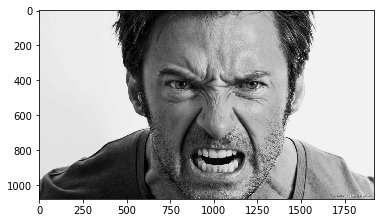

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/model.ckpt-900
anger = 0.0%
disgust = 0.0%
fear = 0.22%
happy = 99.76%
sad = 0.0%
surprise = 0.0%
neutral = 0.02%


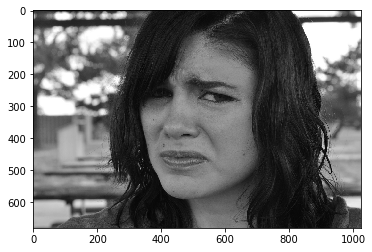

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/model.ckpt-900
anger = 1.96%
disgust = 2.3800000000000003%
fear = 2.76%
happy = 91.56%
sad = 0.0%
surprise = 1.04%
neutral = 0.3%


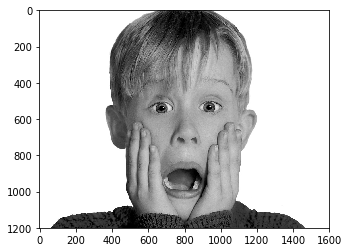

INFO:tensorflow:Restoring parameters from C:/Users/Test.PPMUMCPU0034/Desktop/Predictive Analytics/Section 8/Logs/CNN_logs/model.ckpt-900


KeyboardInterrupt: 

In [17]:
evaluateOnSampleImage(anger)
evaluateOnSampleImage(disgust)
evaluateOnSampleImage(fear)
evaluateOnSampleImage(happy)
evaluateOnSampleImage(neutral)
evaluateOnSampleImage(sad)
evaluateOnSampleImage(surprise)